<h4> Imports and useful functions </h4>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

def logistic(x,x0,y0,k,L):
    '''Logistic function'''
    return L/(1+np.exp(-k*(x-x0))) + y0

def convert_time(time):
    '''Converts the data format into seconds'''
    h,m,s = (time.hour,time.minute,time.second)
    return int(h) * 3600 + int(m) * 60 + int(s)

def get_fit(df,col):
    '''Fit the logistic model and get the best parameters'''
    t = np.array(df.kinetic_read)
    od = np.array(df[col],dtype=float)
    init_vals = [30000, 0, 0.00001, 2]
    try:
        best_vals, covar = curve_fit(logistic, t, od, p0=init_vals)
        return best_vals
    except:
        return [0,0,0,0]

<h4> Getting data </h4>

In [2]:
header = ["kinetic_read","wt_1","wt_2","msn2_1","msn2_2","msn4_1","msn4_2","yap1_1","yap1_2"]

# Read from the excel file and store in a dictionary.
plate_reader = {}
for k in range(1,13): 
    plate_reader[k] = pd.read_excel("20200724_plate3.xlsx",sheet_name="Feuil{}".format(k))
    plate_reader[k].columns=header
    plate_reader[k]['kinetic_read']=plate_reader[k]["kinetic_read"].apply(convert_time)
    plate_reader[k].ix[288,"kinetic_read"]=86662

/Users/andrei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


<h3> Keys </h3> 
1-6 : Concetrations 1000,100,10,1, control and methanol (pesticide solutions are diluted in methanol. <br>
7-12 : same <br>
B7-B12 : 3 YPD and 3 BLANK

![Atrazine](ddt.png)

Text(0.5, 1.0, 'ddt - Concentration 100')

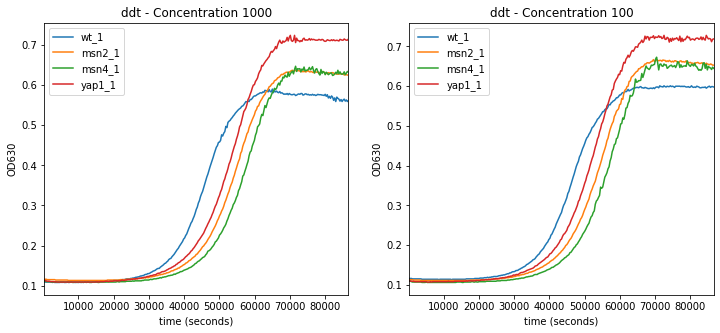

In [3]:
fig,axs = plt.subplots(1,2,figsize=(12,5))

plate_reader[1].plot(x="kinetic_read",y=["wt_1","msn2_1","msn4_1","yap1_1"],ax=axs[0])
axs[0].set_xlabel("time (seconds)")
axs[0].set_ylabel("OD630")
axs[0].set_title("ddt - Concentration 1000")

plate_reader[2].plot(x="kinetic_read",y=["wt_1","msn2_1","msn4_1","yap1_1"], ax=axs[1])
axs[1].set_xlabel("time (seconds)")
axs[1].set_ylabel("OD630")
axs[1].set_title("ddt - Concentration 100")


#plate_reader[2].plot(x="kinetic_read",y="msn4_1")

<h3> Concentration of 100 micrograms per liter </h3> 

Text(0.5, 1.0, 'Atrazine - Concentration 100 microg/l')

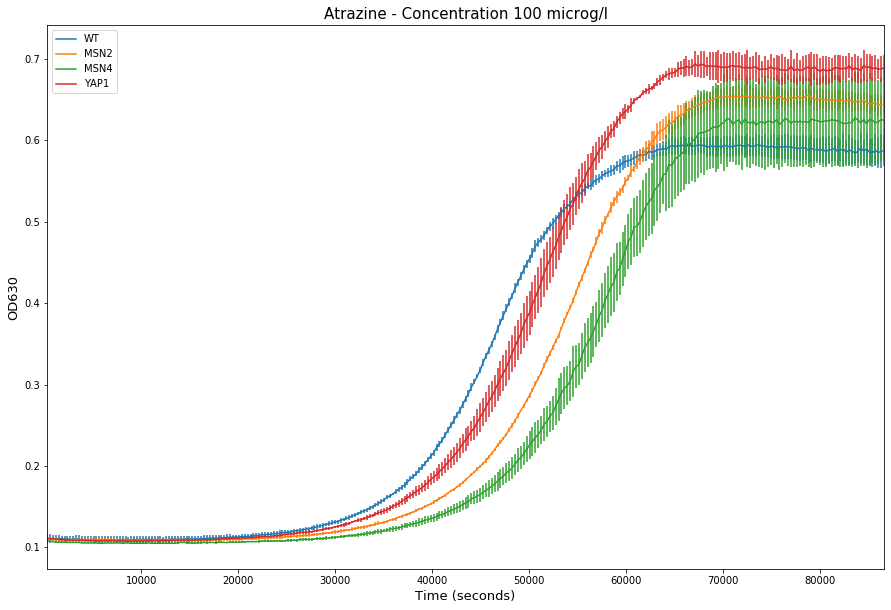

In [4]:
concentration_100_merged = pd.merge(plate_reader[2],plate_reader[8],how='inner',on='kinetic_read')

# Fourth replicate of wt is YPD control.
# We drop the fourth replicate of MSN4 based on the observations of the curves. 

concentration_100_merged = concentration_100_merged.drop(columns=["wt_2_y","msn2_2_y"])

# Mean + std.
concentration_100_merged["WT"] = concentration_100_merged[["wt_1_x","wt_2_x","wt_1_y"]].mean(axis=1)
concentration_100_merged["WT_std"] = concentration_100_merged[["wt_1_x","wt_2_x","wt_1_y"]].std(axis=1)
concentration_100_merged["MSN2"] = concentration_100_merged[["msn2_1_x","msn2_2_x","msn2_1_y"]].mean(axis=1)
concentration_100_merged["MSN2_std"] = concentration_100_merged[["msn2_1_x","msn2_2_x","msn2_1_y"]].std(axis=1)
concentration_100_merged["MSN4"] = concentration_100_merged[["msn4_1_x","msn4_2_x","msn4_1_y"]].mean(axis=1)
concentration_100_merged["MSN4_std"] = concentration_100_merged[["msn4_1_x","msn4_2_x","msn4_1_y"]].std(axis=1)
concentration_100_merged["YAP1"] = concentration_100_merged[["yap1_1_x","yap1_2_x","yap1_1_y","yap1_2_y"]].mean(axis=1)
concentration_100_merged["YAP1_std"] = concentration_100_merged[["yap1_1_x","yap1_2_x","yap1_2_y","yap1_2_y"]].std(axis=1)

# Drop.
concentration_100 = concentration_100_merged[["kinetic_read","WT","WT_std","MSN2","MSN2_std","MSN4","MSN4_std","YAP1",\
                                                "YAP1_std"]]
# Plot with std. 
concentration_100.plot(x="kinetic_read",y=["WT","MSN2","MSN4","YAP1"],\
                       yerr=[concentration_100.WT_std,concentration_100.MSN2_std,concentration_100.MSN4_std,\
                            concentration_100.YAP1_std], figsize=(15,10))
plt.xlabel("Time (seconds)",size=13)
plt.ylabel("OD630",size=13)
plt.title("Atrazine - Concentration 100 microg/l",size=15)

<h3> Growth rate analysis </h3> 

In [7]:
# For each replicate, we want the k coefficient at each concentration as well as controls. 
# For this, create a disctionary in order to store, for each master regulator as well as the wt, the k's for 
# a given concentration. 

regulators_dict = {}

# For each regulator, we store another dictionary : concentrations are keys, the k's for the different replicates 
# are the values. 

for regulator in ["wt","msn2","msn4","yap1"] : 
    regulators_dict[regulator] = {}  # Initialization of the concentrations dictionary. 
    
for k in range(1,13) : # loop over the different concentrations 
    
    concentration = give_concentration(k) # get the corresponding concentration
    
    for column in plate_reader[k].drop(columns=["kinetic_read"]) : # loop over the different regulators for a given concentration
        
        regulator = match_regulator(column) # get the corresponding regulator
        
        if k>=7 and str(column)=="wt_2": #it is YPD and blank
            continue
        
        if k>=7 and str(column)=="msn2_2": #outliers, discard
            continue
        
        k_value = get_fit(plate_reader[k],column)[2] # fit the logistic to the curve, get parameter k
        
        if concentration not in regulators_dict[regulator] : 
            regulators_dict[regulator][concentration] = [k_value] # if concentration not already in dictionary, initialzie
        else : 
            regulators_dict[regulator][concentration].append(k_value) # otherwise just add to the already created list

/Users/andrei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [6]:
concentrations = ["methanol","1000","100","10","1","water"]
regulators = ["wt","msn2","msn4","yap1"]

def give_concentration(k) : 
    ''' Gives correspondance between number of the plate and the concentration'''
    
    return concentrations[k%6]  

def match_regulator(regulator_column) : 
    ''' Matches replicate to regulator based on the column name of the data frame'''
    
    for reg in regulators : 
        if reg in regulator_column : 
            return reg 

In [12]:
regulators_dict

{'wt': {'1000': [0.00023010857540297955,
   0.00022963301508489885,
   0.00022719814241245264],
  '100': [0.0002122597532671109,
   0.00021168095518441543,
   0.0002241112802405176],
  '10': [0.0002167023297862145,
   0.00022242169174692487,
   0.00022767456488347192],
  '1': [0.00021936304893848017,
   0.00022370050149534966,
   0.00022463645987677184],
  'water': [0.0002184890018333683,
   0.00022970566492369412,
   0.00023612762692253283],
  'methanol': [0.00022546136309079274,
   0.00022310282258183384,
   0.00022894474945056524],
  'mean': [0.000228979910966777,
   0.00021601732956401463,
   0.00022226619547220376,
   0.00022256667010353388,
   0.00022810743122653174,
   0.0002258363117077306],
  'std': [1.2747715585985404e-06,
   5.728163170998768e-06,
   4.480745479341659e-06,
   2.2973021786178844e-06,
   7.289080279069742e-06,
   2.3996482011479895e-06]},
 'msn2': {'1000': [0.00021160574647489504,
   0.00020533372910442382,
   0.00020903735680490886],
  '100': [0.0002099306999

In [9]:
# take the mean and the std for the estimates of the paramevers for each regulator. 
# ordered by concentration in the following order : 1000,100,10,1,control,methanol
for regulator in regulators_dict : 
    regulators_dict[regulator]["mean"] = [np.mean(regulators_dict[regulator][concentration]) for concentration in\
                                          regulators_dict[regulator]]
    regulators_dict[regulator]["std"] = [np.std(regulators_dict[regulator][concentration]) for concentration in\
                                         regulators_dict[regulator] if str(concentration)!="mean"]

Text(0, 0.5, 'Growth rate - K')

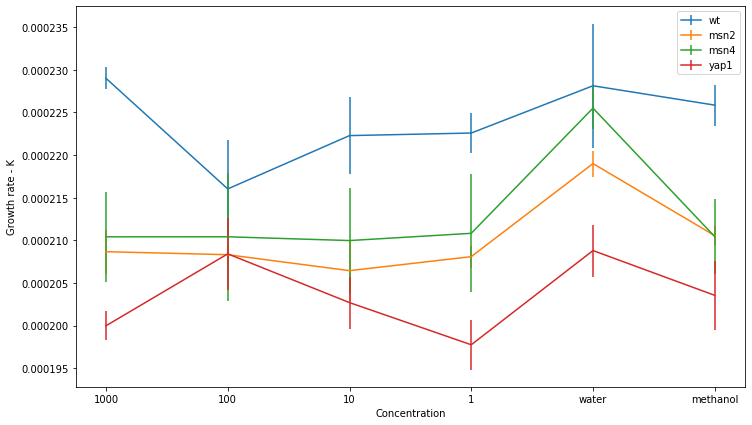

In [10]:
fig,ax = plt.subplots(figsize=(12,7))

for regulator in regulators_dict : 
    ax.errorbar(list(regulators_dict[regulator].keys())[:-2],regulators_dict[regulator]["mean"], label = regulator,\
           yerr=regulators_dict[regulator]["std"])
    
ax.legend()
ax.set_xlabel("Concentration")
ax.set_ylabel("Growth rate - K")

<h2> Pipeline </h2> 

Put everything done before for the growth rate parameter in a pipeline so that we can use it on the other parameters without having to copy paste all the code. It should be adapted according to the data observed. Here, we have seen that the fourth replicate is an outlier so we discard it from every analysis, but it is not necessarily the case for later analysis. YPD and Blank analysis are not included in this pipeline, but they are discarded.

In [11]:
concentrations = ["methanol","1000","100","10","1","water"]
regulators = ["wt","msn2","msn4","yap1"]

def give_concentration(k) : 
    ''' Gives correspondance between number of the plate and the concentration'''

    return concentrations[k%6]  

def match_regulator(regulator_column) : 
    ''' Matches replicate to regulator based on the column name of the data frame'''

    for reg in regulators : 
        if reg in regulator_column : 
            return reg 


def pipeline(choice): 
    '''Get the parameters for a logistic curve fit and plot them for the different strains and concentrations of 
    pesticides.
    Input : the choice of parameter to analyse
    Output : the dictionary containing all the data '''
    
    
    if choice not in ["delay","y0","growth","max"]: 
        print("Please choose between delay,growth,max and y0")
        
    else : 
        param = ["delay","y0","growth","max"].index(choice)
        

    # For each replicate of the regulators, we want the corresponding parameter at each concentration.
    # For this, we create a dictionary in order to store, for each master regulator as well as the wt, a list 
    # containing the parameter value for the different replicates at each concentration.

    regulators_dict = {} #initialize dictionary 

    # For each regulator, we store another dictionary : concentrations are keys, the parameter for the different replicates 
    # are the values, in a list.

    for regulator in ["wt","msn2","msn4","yap1"] : 
        regulators_dict[regulator] = {}  # Initialization of the concentrations dictionary. 

    for k in range(1,13) : # loop over the different concentrations 

        concentration = give_concentration(k) # get the corresponding concentration

        for column in plate_reader[k].drop(columns=["kinetic_read"]) : # loop over the different replicates for a given concentration

            regulator = match_regulator(column) # get the corresponding regulator for this replicate

            if k>=7 and str(column)=="wt_2": #it is YPD and blank
                continue

            if k>=7 and str(column)=="msn2_2": #outliers
                continue

            k_value = get_fit(plate_reader[k],column)[param] # fit the logistic to the curve, get the parameter we want

            if concentration not in regulators_dict[regulator] : 
                regulators_dict[regulator][concentration] = [k_value] # if concentration not already in dictionary, initialize
            else : 
                regulators_dict[regulator][concentration].append(k_value) # otherwise just add to the already created list


    # take the mean and the std across replicates for the estimates of the parameter for each regulator. 
    # ordered by concentration in the following order : 1000,100,10,1,control,methanol
    for regulator in regulators_dict : 
        regulators_dict[regulator]["mean"] = [np.mean(regulators_dict[regulator][concentration]) for concentration in\
                                              regulators_dict[regulator]]
        regulators_dict[regulator]["std"] = [np.std(regulators_dict[regulator][concentration]) for concentration in\
                                             regulators_dict[regulator] if str(concentration)!="mean"]  
    
    # Initialize the figure. 
    fig,ax = plt.subplots(figsize=(12,7))

    # Plot with errorbars corresponding to the std. 
    for regulator in regulators_dict : 
        ax.errorbar(list(regulators_dict[regulator].keys())[:-2],regulators_dict[regulator]["mean"], label = regulator,\
               yerr=regulators_dict[regulator]["std"])

    ax.legend()
    ax.set_xlabel("Concentration")
    ax.set_ylabel(choice)
    
    return regulators_dict  


Remark : We could have plotted the standard error which scales $\frac{1}{\sqrt{n}} = 0.5$ by taking $n=4$ given the fact that we have four replicates. If we want the 95% confidence interval, we should have scaled the standard error by $1.96 \approx 2$, which just simply takes us back to the standard deviation, <b><i> under the assumption that our data is normally distrubuted </i></b> (can be checked with a Shapiro-Wilk test for instance, but quite too few data points). For that reason we just stick with the std. 

/Users/andrei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


{'wt': {'1000': [45364.76562555188, 45740.55144891162, 45672.72864022131],
  '100': [46240.161517995075, 46100.63054285164, 45831.557225083816],
  '10': [45765.973965456695, 46005.1645883097, 45591.00496624327],
  '1': [45560.527054344195, 45811.84006723913, 45748.76030109292],
  'water': [44940.15609074878, 44901.07895310704, 44423.33469426152],
  'methanol': [45330.52254123179, 45681.52738336391, 45208.15495772363],
  'mean': [45592.68190489494,
   46057.449761976844,
   45787.38117333655,
   45707.04247422542,
   44754.85657937245,
   45406.73496077311],
  'std': [163.5223861062991,
   169.58341492039742,
   169.7561968421388,
   106.75467334498866,
   234.96358001783418,
   200.62670644490782]},
 'msn2': {'1000': [53978.838736550075, 53797.8678225737, 53606.39301468556],
  '100': [53644.99870202065, 53590.23543419879, 53360.067412380544],
  '10': [53870.780323116705, 53416.841381718215, 53553.125171671876],
  '1': [53427.23125412044, 53476.82928258666, 53295.74459588298],
  'water'

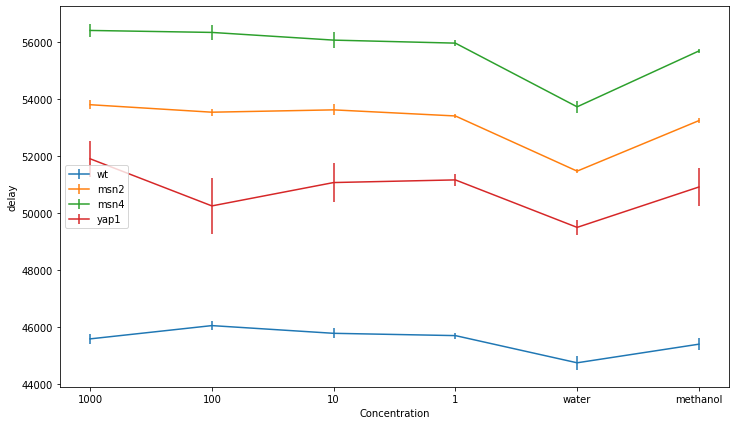

In [13]:
pipeline("delay")

/Users/andrei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


{'wt': {'1000': [0.4667175103791959, 0.4557816199017819, 0.47052510808767645],
  '100': [0.4851162245739965, 0.4909113097571406, 0.4688152367191949],
  '10': [0.4772379348792082, 0.47828309000929187, 0.46611187757360173],
  '1': [0.4748705209876846, 0.4752704249432188, 0.46231841646675376],
  'water': [0.4750445494475737, 0.46022512757627915, 0.4550661354173248],
  'methanol': [0.44727483851086997, 0.48119193534305116, 0.46503149082458645],
  'mean': [0.4643414127895514,
   0.48161425701677735,
   0.4738776341540339,
   0.4708197874658857,
   0.46344527081372594,
   0.4644994215595026],
  'std': [0.006249106111465798,
   0.009354390894242105,
   0.005507771404199678,
   0.006013593625671457,
   0.008468028052357352,
   0.01385170717897314]},
 'msn2': {'1000': [0.5228328135017285, 0.5548518484136735, 0.5273705799567854],
  '100': [0.5546499317066466, 0.5492879155611109, 0.5351829470340836],
  '10': [0.5462886864207969, 0.5452229364939312, 0.5358872240650878],
  '1': [0.5386918142594757,

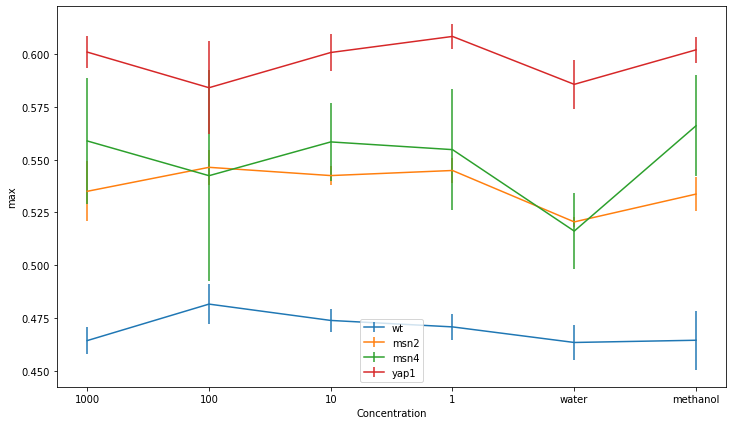

In [14]:
pipeline("max")

/Users/andrei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


{'wt': {'1000': [0.11182081494879158, 0.1151763025397919, 0.11101067369160343],
  '100': [0.11526014979249055, 0.11112510040684263, 0.10943487383518752],
  '10': [0.11477726239418164, 0.11401400413071727, 0.11667586992115198],
  '1': [0.11147564620281758, 0.11252125671107759, 0.11300551064324808],
  'water': [0.10786965114758629, 0.10985440771448036, 0.11157119105225594],
  'methanol': [0.1071947047438361, 0.10931266500941464, 0.11025052259429549],
  'mean': [0.11266926372672897,
   0.11194004134484024,
   0.11515571214868363,
   0.1123341378523811,
   0.10976508330477419,
   0.10891929744918209],
  'std': [0.0018033330108075966,
   0.002446978619168477,
   0.0011191665154877848,
   0.0006384258777040843,
   0.0015124667608672627,
   0.0012781651463143154]},
 'msn2': {'1000': [0.11699770569888263,
   0.12090680823331733,
   0.11259788499138794],
  '100': [0.11550012371181624, 0.11270322910583476, 0.11124463086121993],
  '10': [0.10974959543928879, 0.11713308116154542, 0.111967975652819

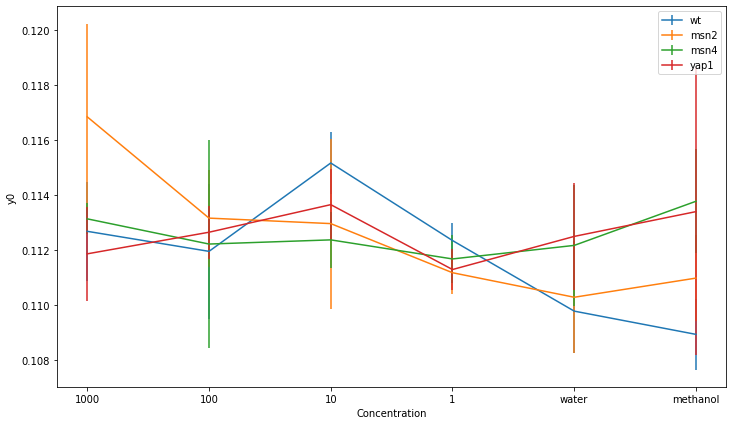

In [15]:
pipeline("y0")